## Random Forest Interpretation

### Intro

Outside of the Data Science world machine learning is thought of as a collection of black box methods. You put numbers in and get an answer and no one really knows why. While that may be the case with some of the fairly complex deep learning models it certainly is not the case for machine learning as a whole. This post will use Random Forest to build a model that predicts Housing Prices and then show some methods that can be used to gain some intuition and understanding of how the model arrived at its predictions. This exploration is inspired by the [Fast.ai](https://www.fast.ai/) Machine Learning course.

Random Forest is an ensemble algorithm based on decision trees. Random Forest is one of the core machine learning algorithms and for good reason. It can be used to do regression (continuous values) as well as classification (discrete values). The Random Forest algorithm takes random subsamples of your dataset and builds decision trees for each of those subsamples, which is also known as bagging. Where Random Forest differs from general Decision Tree bagging is that at each decision point it of the tree instead of always choosing the best variable to split on out of all variables, it makes a selection from a smaller subsample. By doing this along with ensembling trees Random Forest is able to produce robust and uncorrelated models.

### Dataset

The dataset used is from the Kaggle competition [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The goal of the competition was to use the 79 features to predict home prices in Ames, Iowa. The competition utilizes Root-Mean Squared Log Error (RMSLE) as its evaluation metric. 

### Packages

Outside of the data science essential packages (SkLearn, Pandas, Numpy), here are the other packages used:

* [**Altair**](https://altair-viz.github.io/) - Altair aims to be a declarative and easy to use statistical visualization package that is built on top of Vega and Vega-Lite. The API is consistent and takes points from ggplot and Leland Wilkinson's Grammar of Graphics concept. 
* [**Tree Interpreter**](https://github.com/andosa/treeinterpreter) - This package is used to decompose decision tree or random forest predictions into bias and contribution by feature.
* [**PDPbox**](https://pdpbox.readthedocs.io/en/latest/) - The goal of PDPbox is to visualize the impact of certain features towards model prediction for any supervised learning algorithm using partial dependence plots. If you are not familiar with partial dependence it will be explained later in the post.
* [**FancyImpute**](https://github.com/iskandr/fancyimpute) - FancyImpute is used to do Multivariate Imputation by Chained Equations (MICE) and matrix completion. It has several different algorithms that can be used to impute missing values into dataframes.
* [**PyDotPlus**](https://github.com/carlos-jenkins/pydotplus) - Allows python to work with Dot files. This will be used to convert decision trees into images that are viewable inside Jupyter Notebooks.

Alright, let's get started!

In [159]:
from selenium import webdriver
driver = webdriver.Chrome(executable_path='/usr/bin/chromedriver')

In [322]:
from __future__ import division
%load_ext autoreload
%autoreload 2
%matplotlib inline
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from altair.expr import datum
import pydotplus

import pathlib

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

from fancyimpute import IterativeImputer

from IPython.display import Image
%config InlineBackend.figure_format = 'svg'
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
# Read in the dataset
PATH = pathlib.Path("/home/jdoz/Downloads/Data Analysis/Kaggle/Housing/")
df = pd.read_csv(PATH / "house_train.csv")

df.shape

(1460, 81)

Like most other visualization libraries, Altair has the capability to design and save custom themes. This really helps keep consistency across plots while also adding some personalization.

In [324]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Lato');
</style>

In [325]:
def my_theme():
    # Typography
    font = "Lato"
    labelFont = "Lato"
    sourceFont = "Lato"
    markColor = "#353b48"
    # Axes
    axisColor = "#353b48"
    gridColor = "#DEDDDD"
    # Colors
    main_palette = [
        "#1696d2",
        "#d2d2d2",
        "#000000",
        "#fdbf11",
        "#ec008b",
        "#55b748",
        "#5c5859",
        "#db2b27",
    ]
    sequential_palette = [
        "#cfe8f3",
        "#a2d4ec",
        "#73bfe2",
        "#46abdb",
        "#1696d2",
        "#12719e",
    ]
    return {
        "config": {
            "title": {"fontSize": 20, "font": labelFont,"anchor": "start"},
            "background": "transparent",
            "axisX": {
                "domain": True,
                "domainColor": axisColor,
                "domainWidth": 1,
                "grid": False,
                "labelFont": labelFont,
                "labelFontSize": 14,
                #                 "labelAngle": 0,
                "tickColor": axisColor,
                "tickSize": 5,  # default, including it just to show you can change it
                "titleFont": font,
                "titleFontSize": 16,
                "titleColor": axisColor,
                "titlePadding": 10,
                "padding": 20,
            },
            "axisY": {
                "domain": False,
                "grid": False,
                "domainColor": axisColor,
                "gridColor": gridColor,
                "gridWidth": 1,
                "labelFont": labelFont,
                "labelFontSize": 14,
                "labelAngle": 0,
                "tickColor": axisColor,
                "ticks": False,  # even if you don't have a "domain" you need to turn these off.
                "titleFont": font,
                "titleFontSize": 16,
                "titleColor": axisColor,
                "titlePadding": 10,  # guessing, not specified in styleguide
                "titleAngle": 0,  # horizontal
                "titleY": -10,  # move it up
                "titleX": 8,  # move it to the right so it aligns with the labels
            },
            "range": {"category": main_palette, "diverging": sequential_palette},
            "legend": {
                "labelFont": labelFont,
                "labelFontSize": 14,
                "symbolType": "square",  # just 'cause
                "symbolSize": 100,  # default
                "titleFont": font,
                "titleFontSize": 16,
                "orient": "top-left",  # so it's right next to the y-axis
                "offset": 10,  # literally right next to the y-axis.
            },
            "view": {
                "stroke": "transparent"  # altair uses gridlines to box the area where the data is visualized. This takes that off.
            },
 
        },
    }

In [326]:
flatui = {'blue':'#0984e3', 'green':'#00b894','red':'#e17055'}

In [327]:
alt.themes.register("my_theme", my_theme)
alt.themes.enable("my_theme")

ThemeRegistry.enable('my_theme')

Since the competition utilizes RMSLE, instead of writing a function to calculate RMSLE it is much easier to just transform the target variable *SalePrice* and take the RMSE of that. Lets take a look at the distribution of Sale Price before and after the transform is applied.

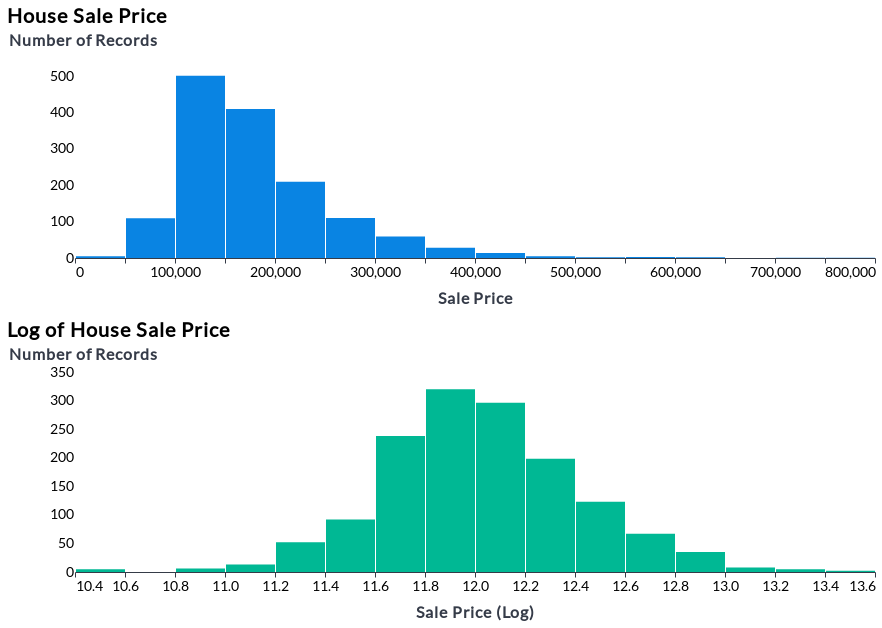

In [328]:
url = "data.json"
df.to_json(url, orient="records")
alt.themes.register("my_theme", my_theme)
alt.themes.enable("my_theme")
alt.renderers.enable('jupyterlab')
base = alt.Chart(df)

reg = (
    base.mark_bar(color=flatui["blue"])
    .encode(
        x=alt.X("SalePrice:Q", bin=alt.Bin(maxbins=20), title="Sale Price"), y="count()"
    )
    .properties(width=800, height=200, title="House Sale Price")
)

trns = (
    base.mark_bar(color=flatui["green"])
    .encode(
        x=alt.X("x:Q", bin=alt.Bin(maxbins=20), title="Sale Price (Log)"), y="count()"
    )
    .transform_calculate(x="log(datum.SalePrice)")
    .properties(width=800, height=200, title="Log of House Sale Price")
)

v = alt.vconcat(reg, trns)
# v.display()
v
# .save(
#     "/home/jdoz/Downloads/Web Development/Projects/DD/static/img/house_dist.svg",
#     format="svg",
#     vegalite_version="3.0.0-rc12",
# )
# # .savechart('/home/jdoz/Downloads/Web Development/Projects/DD/static/img/pict.svg', format='svg')

Although Random Forest is not sensitive to target scaling, the distribution of Sale Price now falls into a nice Normal distribution.

## Data Cleanup

Since the focus of this post is not to explore feature engineering or data cleanup, I will not go into depth on data cleanup for this dataset. The overall cleanup process is fairly standard:
* Remove extreme outliers (this can be fairly dangerous, in general, you don't want to remove records unless it is a verified error
* Handle null/NA values, this either means deleting columns or utilizing imputing techniques such as mean, median, clustering, Bayesian, etc.
* Type correction / transformation. For SkLearns implementation of Random Forest, it is necessary to turn categorical features into numerical values.

In [329]:
# Save a copy of the full dataset
df_raw_full = df.copy()

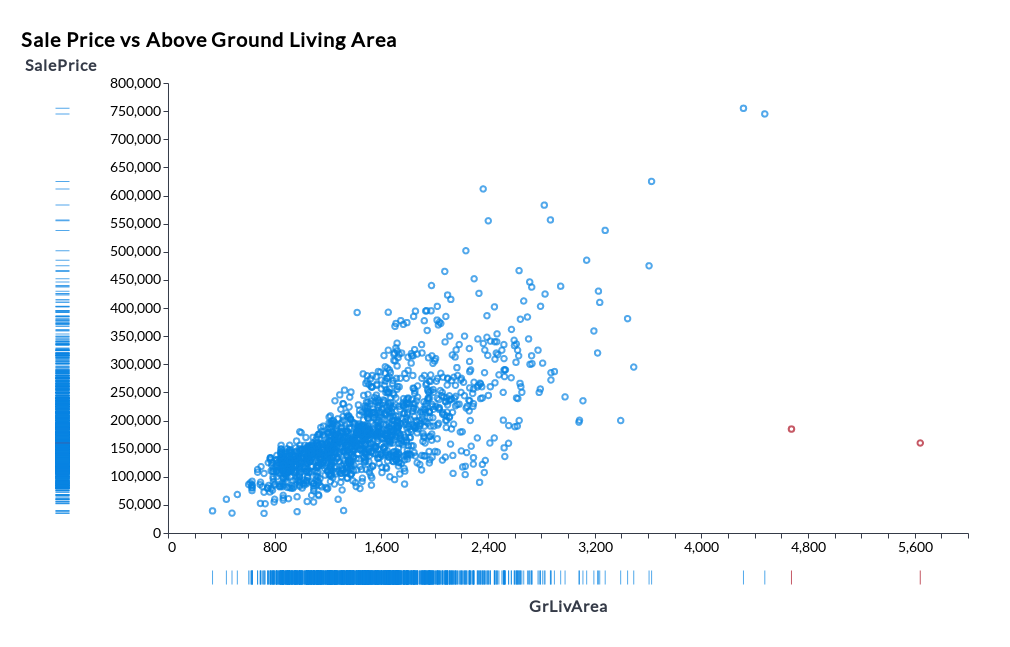

In [330]:
url = "data.json"
df.to_json(url, orient="records")

outlier_color = alt.condition(
    "datum.SalePrice < 300000 && datum.GrLivArea > 4000",
    alt.value("#ae1325"),
    alt.value(flatui["blue"]),
)

base = alt.Chart(df)

points = (
    base.mark_point()
    .encode(
        x=alt.X("GrLivArea:Q", axis=alt.Axis(title="")),
        y=alt.Y("SalePrice:Q", axis=alt.Axis(title="", domain=True, ticks=True)),
        color=outlier_color,
    )
    .properties(height=450, width=800)
)


# Configure the ticks
tick_options = dict(labels=False, domain=False, ticks=False)
tick_axis = alt.Axis(**tick_options)
tick_axis_notitle = alt.Axis(title="", **tick_options)

x_ticks = (
    base.mark_tick()
    .encode(alt.X("GrLivArea:Q", axis=tick_axis), color=outlier_color)
    .properties(width=800)
)

y_ticks = (
    base.mark_tick()
    .encode(alt.Y("SalePrice:Q", axis=tick_axis), color=outlier_color)
    .properties(height=450)
)

padding = {"left": 20, "right": 40, "top": 30, "bottom": 30}
alt.hconcat(
    y_ticks,
    alt.vconcat(points, x_ticks),
    autosize="fit",
    title="Sale Price vs Above Ground Living Area",
    padding=padding,
)

In [331]:
# Transform the target variable
df["SalePrice"] = np.log(df.SalePrice.values)
df = df.drop("Id", axis=1)

# Deleting outliers
df = df.drop(df[(df["GrLivArea"] > 4000) & (df["SalePrice"] < 300000)].index)

df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]


# Some simple boolean features
b_func = lambda x: 1 if x > 0 else 0

df["HasGarage"] = df["GarageCars"].apply(b_func)
df["HasPorch"] = df[["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]].sum(
    axis=1
)
df["HasPorch"] = df["HasPorch"].apply(b_func)
df["HasBsmt"] = df["TotalBsmtSF"].apply(b_func)

df["Age"] = df["YrSold"] - df["YearBuilt"]

df["RemodAge"] = df["YearRemodAdd"] - df["YearBuilt"]
df["HasRemod"] = df["RemodAge"].apply(b_func)

The goal of this post is to focus on looking into Random Forest and not feature engineering / data cleansing, I am going to use fancyimpute to fill in all of the missing values. However, since fancyimpute wants numeric values and we want to impute categorical values as well as numeric, we have to first convert the categorical variables. To do this I will use the Pandas dtype to convert the "object" columns into categories, from there we can use the Pandas method df[SomeSeries].cat.codes to get the integer representation of the categorical variables.  

In [332]:
ocols = df.select_dtypes(include=["object"]).columns
df[ocols] = df[ocols].astype("category")

To be able to convert the categorical variables back into their original values I will create a dictionary that maps the column name to the column values and codes. By default Pandas conveniently converts NaN values to -1 for categorical variables. We can then change those -1's back to NaN so that fancyimpute knows which values to impute.

In [333]:
d = {}
d.update({i: dict(enumerate(df[i].cat.categories)) for i in ocols})

df[ocols] = df[ocols].apply(lambda x: x.cat.codes)

# Uncomment this to also impute categorical variables
# df[ocols] = df[ocols].replace(-1, np.nan)

In [334]:
df_complete = IterativeImputer(n_iter=50, imputation_order="random").fit_transform(df)

df = pd.DataFrame(data=df_complete, columns=df.columns)

And as you can see by using apply and map we can get back to the original values.

In [335]:
df[ocols].apply(lambda x: x.map(d[x.name])).head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3       RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
4       RL   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl   

  Neighborhood Condition1      ...      GarageType GarageFinish GarageQual  \
0      CollgCr       Norm      ...          Attchd          RFn         TA   
1      Veenker      Feedr      ...          Attchd          RFn         TA   
2      CollgCr       Norm      ...          Attchd          RFn         TA   
3      Crawfor       Norm      ...          Detchd          Unf         TA   
4      NoRidge       Norm      ...          Attchd          RFn         TA   

  GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
0         TA          Y    NaN   NaN         NaN       WD        Normal  
1         TA          Y    NaN   NaN         NaN       WD        Normal  
2         TA          Y    NaN   NaN         NaN       WD        Normal  
3         TA          Y    NaN   NaN         NaN       WD       Abnorml  
4         TA          Y    NaN   NaN         NaN       WD        Normal  

[5 rows x 43 columns]

## Predictions

Now on to the predictions! 

In [336]:
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

seed = 3
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

Here are two functions that prints out the models RMSE (RLMSE since 'SalePrice' is transformed) for the training and validation dataset, as well as the out-of-bag (oob) score.

In [337]:
def rmse(x, y):
    return np.sqrt(((x - y)**2).mean())


def print_score(m):
    scores = ['Train RMSE', 'Valid RMSE', 'Train R2', 'Valid R2']
    res = [
        rmse(m.predict(x_train), y_train),
        rmse(m.predict(x_test), y_test),
        m.score(x_train, y_train),
        m.score(x_test, y_test)
    ]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
        scores.append('OOB')
    s = [f'{x}:{y:.4f}\t' for x, y in zip(scores, res)]
    print(" ".join(s))
    
def print_score2(m,x_train, x_test, y_train, y_test):
    scores = ['Train RMSE', 'Valid RMSE', 'Train R2', 'Valid R2']
    res = [
        rmse(m.predict(x_train), y_train),
        rmse(m.predict(x_test), y_test),
        m.score(x_train, y_train),
        m.score(x_test, y_test)
    ]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
        scores.append('OOB')
    s = [f'{x}:{y:.4f}' for x, y in zip(scores, res)]
    print("  ".join(s))   

In [338]:
rf = RandomForestRegressor(
    n_jobs=-1, n_estimators=100, oob_score=True, random_state=seed,
)

rf.fit(x_train, y_train)
print_score(rf)

Train RMSE:0.0527	 Valid RMSE:0.1168	 Train R2:0.9830	 Valid R2:0.8959	 OOB:0.8725	


In [339]:
rf = RandomForestRegressor(
    n_jobs=-1, n_estimators=300, max_features=0.6, oob_score=True, random_state=seed
)

rf.fit(x_train, y_train)
print_score(rf)

Train RMSE:0.0507	 Valid RMSE:0.1108	 Train R2:0.9843	 Valid R2:0.9064	 OOB:0.8826	


Below is the baseline model using all of the features (79). However, we want to try to make our model as simple as possible by reducing the number of features without sacrificing overall accuracy. 

**Hyper Parameters**

In the above models, the Random Forest's training RMSE was much lower than the validation RMSE which means that the model is overfitting to the training data. For Random Forest there are several different things that you can do to decrease the amount of overfitting. Below I set the *max_features* to *sqrt*, which limits the number of variables a tree has available to use at each split. I also increased the *min_samples_leaf* to 5. This means each tree will split down until it has 5 samples in each leaf instead of having a leaf for each individual sample. 

The result is a model that is slightly less accurate on the training data however it is a more robust estimator.

In [340]:
rf = RandomForestRegressor(
    n_jobs=-1,
    n_estimators=2000,
    max_features='sqrt',
    oob_score=True,
    min_samples_leaf=5,
    random_state=seed,
)

rf.fit(x_train, y_train)
print_score(rf)

Train RMSE:0.1078	 Valid RMSE:0.1176	 Train R2:0.9288	 Valid R2:0.8945	 OOB:0.8707	


## Feature Importance

Feature Importance works by randomly shuffling a feature in place and testing the model's accuracy. Feature Importance represents the delta in prediction accuracy before and after the shuffle for each feature. Variables that are shuffled and drastically reduce the overall accuracy of the model indicate that the particular feature is important to the model. Features that are shuffled and the overall accuracy remains similar indicate that the feature is less important.

While Feature Importance can be interpreted similarly to the coefficient of a variable in linear regression (coefficients that are larger have a greater impact on the dependent variable) linear regression models have to meet a lot of assumptions to be completely accurate. 

We can attempt to make our overall model simpler by removing features that have little to no impact on predictions. Simpler models, in general, are much easier to interpret. We can plot the Feature Importance's of our variables and determine a cutoff point for variables that we will remove from the model. We want to be careful here not to set the cutoff point too high as sometimes less important variables have some interaction with other variables that could make them more important or meaningful.

In [341]:
fi = [[x,y] for x,y in zip(x_train.columns,rf.feature_importances_)]
fi = pd.DataFrame(data=fi,columns=['feat','imp']).sort_values('imp', ascending=False)
fi = fi.loc[fi['imp']>0.0001]

In [342]:
# Only keep variables who's importance is at or above this threshold
cutoff = 0.002
fi['keep'] = fi['imp'].apply(lambda x: 'Keep' if x >= cutoff else 'Drop')
keep_cols = fi.loc[fi.imp >= cutoff].feat.values

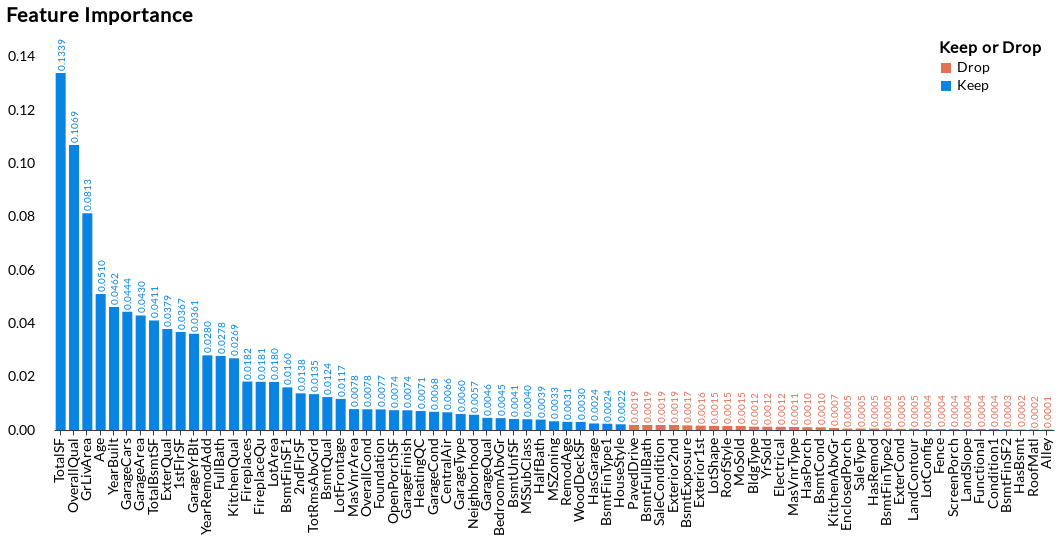

In [343]:
url = "data.json"
fi.to_json(url, orient="records")

sort = sort = alt.EncodingSortField(field="imp", op="sum", order="descending")
rng = [flatui["red"], flatui["blue"]]

base = alt.Chart(fi, title="Feature Importance")

bars = base.mark_bar(size=10).encode(
    x=alt.X("feat:N", sort=sort, title=None),
    y=alt.Y("imp:Q", title=None),
    color=alt.Color(
        "keep:N",
        scale=alt.Scale(range=rng),
        legend=alt.Legend(orient="top-right", title="Keep or Drop"),
    ),
)

text = bars.mark_text(
    align="center", baseline="middle", angle=270, size=10,font='Lato', dx=18, dy=1, color="#c0392b"
).encode(
    x=alt.X(
        "feat:N",
        sort=sort,
        title=None,
        axis=alt.Axis(False, labels=False, ticks=False),
    ),
    text=alt.Text("imp:Q", format=".4f"),
)


(bars + text).properties(height = 400,width=1000).configure_axisY(labelPadding=20).resolve_scale(x="independent")

Now we reset our training and validation set to only have the variables above the cut off point and retrain the model.

In [344]:
X = df[keep_cols]
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = seed) 

rf.fit(x_train, y_train)
print_score(rf)

Train RMSE:0.1058	 Valid RMSE:0.1159	 Train R2:0.9314	 Valid R2:0.8975	 OOB:0.8733	


As you can see the RMSE of the validation set actually improved by reducing the number of variables. So not only is the model simpler it is also more accurate. Let's see if we can take it a step further.

## Removing Redundant Features

We can further reduce the number of features by removing features that are highly correlated with each other. We will use hierarchical clustering to determine which variables are highly correlated and redundant.

In [345]:
from bokeh.palettes import Category10_10, Category20_20

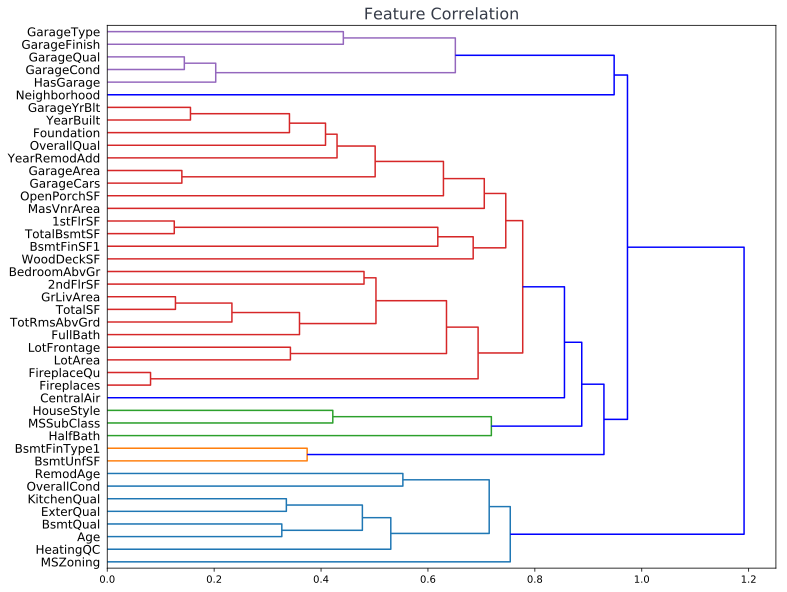

In [346]:
from scipy.cluster import hierarchy as hc
import scipy

corr = np.round(scipy.stats.spearmanr(x_test).correlation, 4)
corr_condensed = hc.distance.squareform(1 - corr)
hc.set_link_color_palette(Category10_10)
z = hc.linkage(corr_condensed, method="average")

fig = plt.figure(figsize=(12, 10))

dendrogram = hc.dendrogram(
    z, labels=x_test.columns, orientation="right", leaf_font_size=12
)
plt.title('Feature Correlation',size = 16, color = '#353b48')
plt.savefig('house_deng.svg', dpi = 150)

Variables that connect furthest to the right, are considered similar. We can take each pair of highly correlated features and test how dropping out one of the features from the model affects accuracy. We can then drop the variable that results in worse performance from the training and test dataset.

We establish a 0.2 threshold for the linkage metric, features below this point will be added to our list of features that we can potentially drop. Unlike feature importance we will not drop all of the features below this point, we will select one from each pair to drop and one to keep.

In [347]:
x_cols = x_test.columns.tolist()
cols = [x_cols[int(x)] for x in z[z[:, 2] < 0.2][:, :2].flatten()]
df_keep = df[keep_cols.tolist() + ["SalePrice"]]

In [348]:
# This function is the base estimator that will be used to test the accuracy after dropping each variable
def get_oob(df):
    xx = df.drop('SalePrice', axis = 1)
    yy = df.SalePrice
    m = RandomForestRegressor(n_estimators=50, max_features = 0.6, n_jobs=-1, oob_score=True, random_state = seed)
    x_train, x_test, y_train, y_test = train_test_split(xx,yy, test_size = 0.2, random_state = seed) 
    m.fit(xx,yy)
    return print_score2(m,x_train, x_test, y_train, y_test)

**Baseline Score**

First, get the baseline score of the model as-is with all of the current variables in the dataset.

In [349]:
get_oob(df_keep)

Train RMSE:0.0526  Valid RMSE:0.0396  Train R2:0.9831  Valid R2:0.9880  OOB:0.8821


Now we will iterate through each highly correlated feature and drop it from the dataset and train and evaluate the results of the model.

In [350]:
for c in cols:
    print(f'\n{c}')
    get_oob(df_keep.drop(c, axis=1))


Fireplaces
Train RMSE:0.0511  Valid RMSE:0.0413  Train R2:0.9840  Valid R2:0.9870  OOB:0.8878

FireplaceQu
Train RMSE:0.0513  Valid RMSE:0.0417  Train R2:0.9839  Valid R2:0.9868  OOB:0.8875

TotalBsmtSF
Train RMSE:0.0521  Valid RMSE:0.0406  Train R2:0.9834  Valid R2:0.9874  OOB:0.8852

1stFlrSF
Train RMSE:0.0526  Valid RMSE:0.0424  Train R2:0.9830  Valid R2:0.9863  OOB:0.8790

TotalSF
Train RMSE:0.0524  Valid RMSE:0.0406  Train R2:0.9832  Valid R2:0.9874  OOB:0.8805

GrLivArea
Train RMSE:0.0528  Valid RMSE:0.0422  Train R2:0.9829  Valid R2:0.9864  OOB:0.8797

GarageCars
Train RMSE:0.0527  Valid RMSE:0.0411  Train R2:0.9830  Valid R2:0.9871  OOB:0.8804

GarageArea
Train RMSE:0.0518  Valid RMSE:0.0404  Train R2:0.9836  Valid R2:0.9876  OOB:0.8834

GarageCond
Train RMSE:0.0520  Valid RMSE:0.0410  Train R2:0.9834  Valid R2:0.9871  OOB:0.8841

GarageQual
Train RMSE:0.0525  Valid RMSE:0.0412  Train R2:0.9831  Valid R2:0.9871  OOB:0.8823

YearBuilt
Train RMSE:0.0526  Valid RMSE:0.0410  Train

In [351]:
to_drop = ['GarageQual','GarageYrBlt','GrLivArea','GarageArea','1stFlrSF']
get_oob(df_keep.drop(to_drop, axis=1))

Train RMSE:0.0525  Valid RMSE:0.0392  Train R2:0.9831  Valid R2:0.9883  OOB:0.8830


When comparing the 2 variables we want to select the variable that when dropped decreases the RMSE or has a higher OOB score than the other. From our comparison, we are able to drop *GrLivArea*, *GarageArea*, *TotalBsmtSF*. Now we test the model again with all of those variables dropped, and we can see that by dropping those 3 variables we get an additional decrease in RMSE. 

## One Hot Encoding

In [352]:
# Refit a baseline model
df_keep = df_keep.drop(to_drop, axis=1)
X = df_keep.drop("SalePrice", axis=1)
y = df_keep["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

rf = RandomForestRegressor(
    n_estimators=1000,
    max_features="sqrt",
    min_samples_leaf=5,
    n_jobs=-1,
    oob_score=True,
    random_state=seed,
)
rf.fit(x_train, y_train)
print_score(rf)

Train RMSE:0.1063	 Valid RMSE:0.1140	 Train R2:0.9308	 Valid R2:0.9009	 OOB:0.8750	


In [353]:
# Variables with values less than this number will be transformed to one hot encoded
n_cats = 7
ocols_keep = [x for x in df_keep.columns if x in ocols]

In [354]:
df1 = df_keep.copy()
for col in ocols_keep:
    if df1[col].nunique()<=n_cats:
        df1 = pd.concat((df1,pd.get_dummies(df1[col], prefix = col)), axis = 1)
        df1.drop(col, axis = 1, inplace = True)
    else: pass

In [355]:
# Refit a baseline model
X = df1.drop("SalePrice", axis=1)
y = df1["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

rf = RandomForestRegressor(
    n_estimators=1000,
    max_features="sqrt",
    min_samples_leaf=5,
    n_jobs=-1,
    oob_score=True,
    random_state=seed,
)
rf.fit(x_train, y_train)
print_score(rf)

Train RMSE:0.1143	 Valid RMSE:0.1169	 Train R2:0.9200	 Valid R2:0.8958	 OOB:0.8675	


Actually got worse, however sometimes we can see some variables Importance may increase...

In [356]:
fi = [[x,y] for x,y in zip(x_train.columns,rf.feature_importances_)]
fi = pd.DataFrame(data=fi,columns=['feat','imp']).sort_values('imp', ascending=False)

In [357]:
new_keep = fi.loc[fi['imp'] > 0.01]['feat'].values.tolist()

In [358]:
fi.head(10)

feat       imp
0           TotalSF  0.138162
1       OverallQual  0.110894
2               Age  0.056774
4        GarageCars  0.055243
5       TotalBsmtSF  0.054348
3         YearBuilt  0.053062
29    ExterQual_3.0  0.044464
7          FullBath  0.038118
6      YearRemodAdd  0.036839
33  KitchenQual_3.0  0.027755

In [359]:
df_keep = df1[new_keep]
df_keep['SalePrice'] = y

/home/jdoz/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Confidence based on Tree Variance

Now, let's re-fit a baseline model. One way to gain insight into areas where the model may struggle to produce accurate predictions is to look at the confidence of the prediction based on the individual tree variances. 

We will stack the predictions from each tree and see how a prediction may vary based on a given feature.

Recap: Feature importance - very key for finding top features

Few features have most of the importance: Find only the feature importance's over a certain threshold

Collinearity distributes importance: random forests deal with collinearity very well, but one by-product is that collinear fields will ‘steal’ importance. The total importance will be distributed between the column.

Feature filtering will consolidate importance: Feature importance filtering and recalculating will reconsolidate importance in the key fields

**Make a Single Tree**

In [360]:
df_keep.columns

Index(['TotalSF', 'OverallQual', 'Age', 'GarageCars', 'TotalBsmtSF',
       'YearBuilt', 'ExterQual_3.0', 'FullBath', 'YearRemodAdd',
       'KitchenQual_3.0', 'Fireplaces', 'LotArea', 'FireplaceQu_-1.0',
       'TotRmsAbvGrd', 'LotFrontage', '2ndFlrSF', 'ExterQual_2.0',
       'BsmtFinSF1', 'Foundation_2.0', 'BsmtQual_0.0', 'OpenPorchSF',
       'BsmtQual_3.0', 'SalePrice'],
      dtype='object')

In [361]:
# df_keep = df_keep.drop(to_drop, axis=1)
X = df_keep.drop("SalePrice", axis=1)
y = df_keep["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

rf = RandomForestRegressor(
    n_estimators=10,
    max_features=0.6,
    max_depth=3,
    min_samples_leaf=5,
    n_jobs=-1,
    oob_score=True,
    random_state=seed,
)
rf.fit(x_train, y_train);

/home/jdoz/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [306]:
estimator = rf.estimators_[1]

# Export as dot file
dot_data = export_graphviz(estimator, out_file=None, 
                feature_names = X.columns.values,
                class_names = y.name,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

graph = pydotplus.graph_from_dot_data(dot_data)

colors = ("#0984e3", "#00b894")
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png("tree.png")
Image(filename="tree.png")

InvocationException: GraphViz's executables not found

We can then take a feature of interest and see how the leaf nodes vary across all of the trees. By seeing how the predictions vary for individual features it can help you understand which features or which value of a feature we can place more confidence in the resulting predictions.

In [362]:
# Refit a baseline Model
X = df_keep.drop("SalePrice", axis=1)
y = df_keep["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

rf = RandomForestRegressor(
    n_estimators=100,
    max_features=0.6,
    min_samples_leaf=5,
    n_jobs=-1,
    oob_score=True,
    random_state=seed,
)
rf.fit(x_train, y_train)
print_score(rf)

Train RMSE:0.1048	 Valid RMSE:0.1223	 Train R2:0.9328	 Valid R2:0.8859	 OOB:0.8610	


So we will iterate through all of the single estimators (trees) that the Random Forest creates and get individual predictions for the decision tree. We then stack each prediction then take the standard deviation across those predictions. We then group our predictions by the feature of interest and can evaluate how the standard deviation across the predictions vary.

In [363]:
group_col = "OverallQual"
# group_col = 'BedroomAbvGr'
xr = x_test.copy()

preds = np.stack([t.predict(x_test) for t in rf.estimators_])
np.mean(preds[:, 0]), np.std(preds[:, 0])

xr["SalePrice"] = y_test.values
xr["pred_std"] = np.std(preds, axis=0)
xr["pred"] = np.mean(preds, axis=0)

We can see that the standard deviation on houses that have an overall quality of 0 have the most variation in our predictions. 

In [364]:
flds = [group_col, "SalePrice", "pred", "pred_std"]
qual = xr[flds].groupby(group_col, as_index=False).mean()
qual

OverallQual  SalePrice       pred  pred_std
0          2.0  11.002100  11.070021  0.241497
1          4.0  11.626306  11.615726  0.152892
2          5.0  11.782335  11.772675  0.123638
3          6.0  11.956510  11.952136  0.111577
4          7.0  12.232070  12.250844  0.113475
5          8.0  12.474454  12.500454  0.120462
6          9.0  12.769813  12.715936  0.124559
7         10.0  13.031520  12.928556  0.142822

While standard deviation measures the variance in the predictions, it is important to also note the observation size of each of the values. We can now use Altair to plot the frequency as well as the average predictions and error. As you would expect, values that are not well represented in the data tend to have a higher variance in our predictions, which intuitively makes sense.

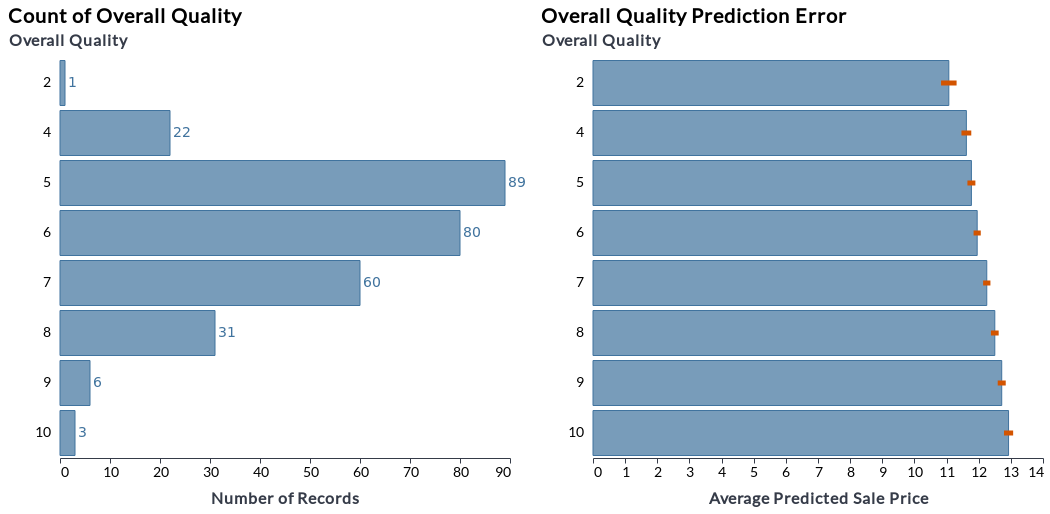

In [365]:
url = "data0.json"
xr.to_json(url, orient="records")

cnt = (
    alt.Chart(url, title="Count of Overall Quality")
    .mark_bar(
        color="#40739e", line=True, stroke="#40739e", fill="rgba(64, 115, 158,.70)"
    )
    .encode(x="count()", y=alt.Y(f"{group_col}:N", title="Overall Quality"))
    .properties(height=400, width=450)
)

text = cnt.mark_text(align="left", baseline="middle",size = 14, dx=3, color="#40739e").encode(
    text="count():Q"
)


url = "data1.json"
qual.to_json(url, orient="records")

bars = (
    alt.Chart(url, title="Overall Quality Prediction Error")
    .mark_bar(
        color="#40739e", line=True, stroke="#40739e", fill="rgba(64, 115, 158,.70)"
    )
    .encode(x="pred:Q", y=alt.Y(f"{group_col}:N", title="Overall Quality"))
).properties(height=400, width=450)

errorbars = (
    bars.mark_rule(color="#d35400", size=5)
    .encode(
        y=f"{group_col}:N",
        x=alt.X("ymin:Q", title="Average Predicted Sale Price"),
        x2="ymax:Q",
    )
    .transform_calculate(
        ymin="datum.pred-datum.pred_std", ymax="datum.pred+datum.pred_std"
    )
)

(cnt + text | bars + errorbars).configure_axisY(labelPadding=10)

## Tree Interpreter

Tree Interpreter is a great package that takes each split in the trees of the random forest and shows the average increase or decrease based on the values you are trying to predict.

The tree interpreter returns 3 items:
* The prediction from the random forest model.
* The model bias, which is the average of the dependent variable across the entire dataset. This is the starting point of the decision tree.
* The contributions for each feature in the model. This is the increase or decrease in the prediction based on the value of the feature being predicted.

So let's take a look at an example. Here are the values for the first element in the training dataset.

In [366]:
from treeinterpreter import treeinterpreter as ti

row = x_test.values[None, 0]
x_test.iloc[0]

TotalSF              1728.0
OverallQual             4.0
Age                    39.0
GarageCars              0.0
TotalBsmtSF           864.0
YearBuilt            1971.0
ExterQual_3.0           1.0
FullBath                1.0
YearRemodAdd         1971.0
KitchenQual_3.0         1.0
Fireplaces              1.0
LotArea             10500.0
FireplaceQu_-1.0        0.0
TotRmsAbvGrd            5.0
LotFrontage            70.0
2ndFlrSF                0.0
ExterQual_2.0           0.0
BsmtFinSF1            432.0
Foundation_2.0          0.0
BsmtQual_0.0            0.0
OpenPorchSF             0.0
BsmtQual_3.0            1.0
Name: 140, dtype: float64

In [367]:
# TreeInterpreter takes in the random forest model as well as the prediction row.
prediction, bias, contribution = ti.predict(rf, row)

print(f"Prediction: {prediction[0][0]:.2f}, Bias: {bias[0]:.2f}")

Prediction: 11.62, Bias: 12.02


In [368]:
# Take a look at the column, prediction input and the contribution. 
# This is the data that will be turned into a waterfall plot
idxs = np.argsort(contribution)[0]
[
    print(f"Feature: {o[0]}\tRow Input: {o[1]:g}\tContribution: {o[2]:.3f}")
    for o in zip(x_test.columns[idxs], x_test.iloc[0][idxs], contribution[0][idxs])
];

Feature: OverallQual	Row Input: 4	Contribution: -0.224
Feature: TotalSF	Row Input: 1728	Contribution: -0.184
Feature: GarageCars	Row Input: 0	Contribution: -0.060
Feature: ExterQual_3.0	Row Input: 1	Contribution: -0.010
Feature: TotRmsAbvGrd	Row Input: 5	Contribution: -0.004
Feature: FullBath	Row Input: 1	Contribution: -0.002
Feature: OpenPorchSF	Row Input: 0	Contribution: -0.001
Feature: 2ndFlrSF	Row Input: 0	Contribution: -0.001
Feature: KitchenQual_3.0	Row Input: 1	Contribution: -0.001
Feature: BsmtQual_3.0	Row Input: 1	Contribution: -0.000
Feature: ExterQual_2.0	Row Input: 0	Contribution: 0.000
Feature: Foundation_2.0	Row Input: 0	Contribution: 0.000
Feature: BsmtQual_0.0	Row Input: 0	Contribution: 0.000
Feature: YearRemodAdd	Row Input: 1971	Contribution: 0.001
Feature: LotFrontage	Row Input: 70	Contribution: 0.001
Feature: Fireplaces	Row Input: 1	Contribution: 0.004
Feature: YearBuilt	Row Input: 1971	Contribution: 0.004
Feature: FireplaceQu_-1.0	Row Input: 0	Contribution: 0.005
Fe

### Tree Interpreter Visualization

Now we are going to take the bias, contributions, and the original inputs and create a waterfall chart that tracks the contributions across each input.

In [369]:
names = ['Base'] + x_test.columns[idxs].tolist()
contribution = [0] + contribution[0][idxs].tolist()

In [370]:
ti_df = pd.DataFrame(data = {'name':names, 'change':contribution})

In [371]:
ti_df['result'] = 0 
ti_df['result'] = ti_df['change']
ti_df.loc[ti_df['name'] == 'Base', 'result'] = bias


ti_df['result'] = ti_df['result'].cumsum()
ti_df['base'] = ti_df['result'].shift(periods = 1).fillna(0)

ti_df['bottom'] = ti_df[['result', 'base']].min(axis = 1)
ti_df['top'] = ti_df[['result', 'base']].max(axis = 1)

In [372]:
rowc = x_test.iloc[0]

# This maps the index to the original rows input for the continuous features

ti_df['input'] = rowc
ti_df['input'] = ti_df['name'].map(rowc)
ti_df['input'].fillna('Base', inplace = True)

In [373]:
# Get the original categorical input
for key, val in rowc.items():
    if key in d:
        if val == -1:
            ti_df.loc[ti_df["name"] == key, "input"] = "Blank"
        else:
            ti_df.loc[ti_df["name"] == key, "input"] = d[key][val]

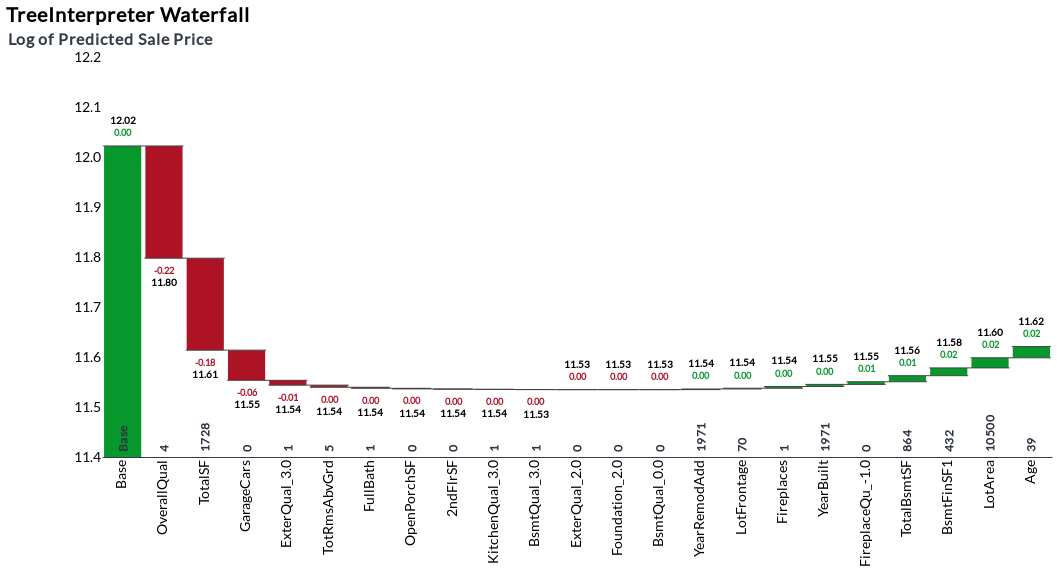

In [376]:
open_close_color = alt.condition(
    "datum.base < datum.result", alt.value("#06982d"), alt.value("#ae1325")
)

base = alt.Chart(ti_df, title="TreeInterpreter Waterfall")

bars = base.mark_bar(clip=True).encode(
    x=alt.X("name:N", sort=alt.Sort(None), title=None),
    y=alt.Y(
        "base:Q",
        title="Log of Predicted Sale Price",
        scale=alt.Scale(domain=(11.4, 12.2)),
    ),
    y2="result",
    color=open_close_color,
)

# Linewidth is ~plot width / bars*2
lw = 900 / (ti_df.shape[0] * 2)

line = (
    base.transform_window(lead="lead(name)")
    .transform_calculate(lead="datum.lead == null ? datum.name : datum.lead")
    .mark_rule(xOffset=-lw, x2Offset=lw, stroke="#444", strokeWidth=1)
    .encode(x=alt.X("name:O", sort=alt.Sort(None)), x2="lead:O", y="result:Q")
)

bias_text = (
    base.mark_text(
        align="center", baseline="middle", fontWeight="bold", fontSize=10, font="Lato"
    )
    .encode(
        x=alt.X("name:O", sort=alt.Sort(None)),
        y=alt.Y("center:Q", axis=None),
        text=alt.Text("result:Q", format=".2f"),
    )
    .transform_calculate(center="datum.change >= 0 ? datum.top+.05 : datum.bottom-.05")
)

contrib_text = (
    base.mark_text(
        fontWeight="bold", align="center", baseline="middle", fontSize=9, font="Lato"
    )
    .encode(
        x=alt.X("name:O", sort=alt.Sort(None)),
        y=alt.Y("center:Q", axis=None),
        text=alt.Text("change:Q", format=".2f"),
        color=open_close_color,
    )
    .transform_calculate(
        center="datum.change >= 0 ? datum.top + 0.025 : datum.bottom - 0.025"
    )
)

input_text = (
    base.mark_text(
        color="#2f3542",
        fontWeight="bold",
        fontSize=12,
        font="Lato",
        angle=270,
        align="left",
        baseline="middle",
    )
    .encode(
        x=alt.X("name:O", sort=alt.Sort(None)), y="center:Q", text=alt.Text("input:N")
    )
    .transform_calculate(center="datum.change >= 0 ? 11.41 : 11.41")
    .transform_filter('datum.name != "base"')
)

(bars + line + bias_text + contrib_text + input_text).configure_tick(
    bandSize=10
).configure_scale(rangeStep=10).configure_axisX(ticks=False).properties(width=950, height = 400)

From the chart above you can quickly see that the overall quality, total square feet, and the fact that it doesn't have a garage had the greatest negative impact on the prediction. 

## Partial Dependence

The partial dependence plot (PDP) shows the marginal effect one or two features have on the predicted outcome of a machine learning model. A partial dependence plot visualizes the relationship between a target and feature. Much like feature importance, partial dependence alters the dataset being predicted then monitors the effect on the predictions. Unlike feature importance, instead of randomly shuffling the feature of interest, it sets the entire column to a single value, makes a prediction and compares that prediction to the overall average of the dataset. It does this for each unique value within a feature column. By doing this you are able to measure how much above or below a feature value is as compared to the mean. PDP is not limited to only Random Forest and can be used on almost any predictive model. Let's take a look at some examples.

This is the  function that will be used to calculate the PDP and plot the results. The PDP function requires an already fitted model and a dataset.

In [377]:
from pdpbox import pdp
from plotnine import *

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(rf, x_train, feat)
    return pdp.pdp_plot(
        p,
        feat_name,
        plot_lines=True,
        cluster=clusters is not None,
        n_cluster_centers=clusters,
        figsize = (12,7)
    )

In [675]:
# Set a baseline Random Forest Model

rf = RandomForestRegressor(
    n_jobs=-1, n_estimators=500, max_features=0.6,min_samples_leaf=5, oob_score=True
)
rf.fit(x_train, y_train)
print_score(rf)

['Train RMSE:0.1041', 'Valid RMSE:0.1213', 'Train R2:0.9337', 'Valid R2:0.8879', 'OOB:0.8655']


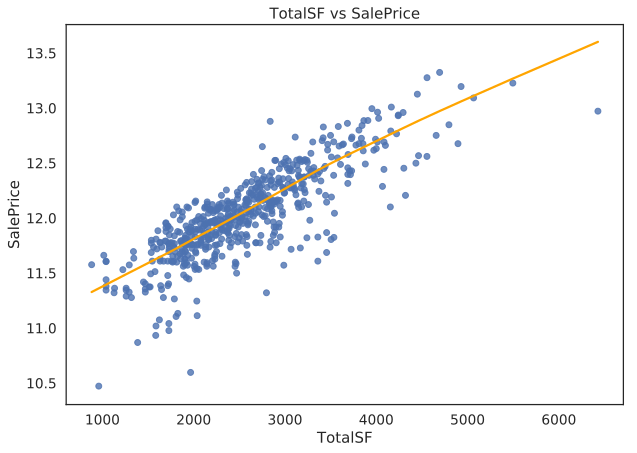

In [676]:
temp = x_train.copy()
temp["SalePrice"] = y_train
temp = temp.sample(frac=0.5)

sns.set(style="white", font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.regplot(
    x="TotalSF", y="SalePrice", data=temp, lowess=True, line_kws={"color": "orange"}
)
ax.set(title="TotalSF vs SalePrice")
plt.show()

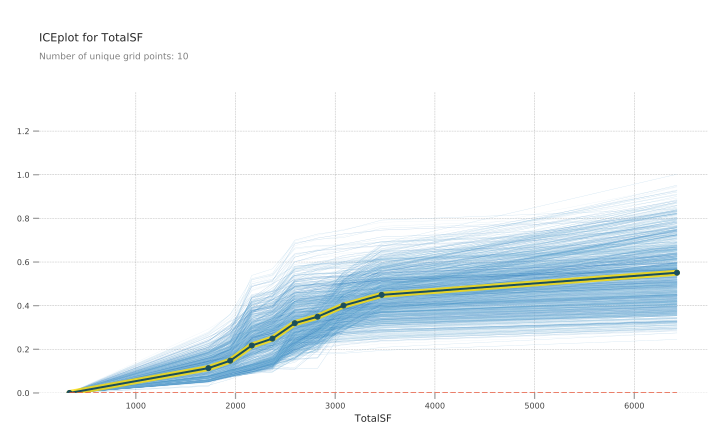

In [677]:
plot_pdp(feat = 'TotalSF')

To orient you to the chart, the y-axis represents the effect above the average. The yellow line is the average effect for all data points and the blue lines represent each individual row in the dataset. It is possible to cluster the blue-lines to see the shape of how clusters move together.

From this plot of Total Square Foot, we can see that as the Total Square Feet of a house increases the Sale Price also increases. Intuitively this makes sense, the benefit of the PDP is that we can see the behavior of this increase over the range of values for Total Square Feet. You can see that at a certain point the Total Square Feet of a house does not have the same impact and the effect seems to level off.

When compared to a scatter plot with a Lowess line, you can see how one might be deceived by the shape of the plot. This is because a simple scatter plot doesn't account for the interactions of all of the other features. PDP can be interpreted as the impact of a variable given that all other features are the same. 

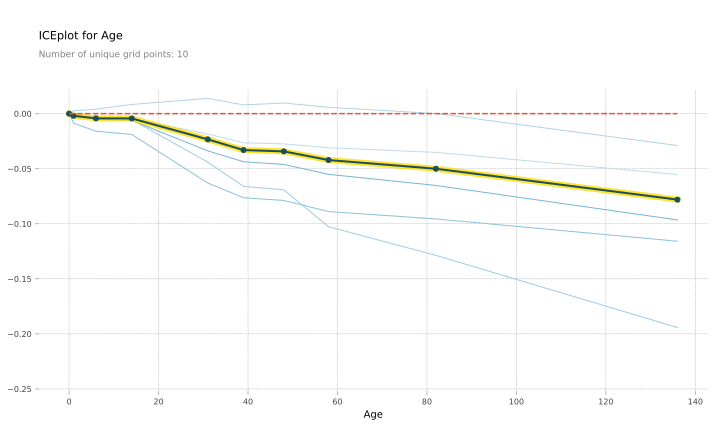

In [224]:
plot_pdp(feat = 'Age' , clusters=5);

## Accumulated Local Effects (ALE) Plot

Accumulated Local Effects plots describe how features influence the prediction of a machine learning model on average. ALE plots are a faster and unbiased alternative to partial dependence plots (PDPs). A good explanation of ALE is [here](https://christophm.github.io/interpretable-ml-book/ale.html). 

If the features of a machine learning model are correlated, the partial dependence plot cannot be trusted. The computation of a partial dependence plot for a feature that is strongly correlated with other features involves averaging predictions of artificial data instances that are unlikely in reality. This can greatly bias the estimated feature effect. In the above example where we looked at the partial dependence of Total Sq Ft, the partial dependence algorithm would try to calculate infeasible designs of houses, for instance, a 333 sq ft house with 6 bedrooms. Since ALE only accumulates the effects over the ranges where actual values exist it is a better reflection of the actual effect given the data points in the dataset.

Currently, there are no Python libraries that implement ALE, [here](https://cran.r-project.org/web/packages/ALEPlot/index.html) is the link to the R package as well as the original paper. After reviewing the paper I wrote a simple implementation for ALE for a single dependent variable.

The ALE calculation broken down is:
* Divide your dataset into bins
* Calculate the effect by calculating the difference between the uppermost value of the bin and the lowest value
* Take the average of those values for each bin
* Accumulate the averages of the bins

In [378]:
from collections import Counter, defaultdict
from sklearn.preprocessing import StandardScaler

In [379]:
def get_ALE(df, feat, bins):
    df = df.copy()
    pred_cols = df.columns.values
    df["q"] = pd.qcut(df[feat], q=bins)
    df["right"] = df["q"].apply(lambda x: x.right)
    df["left"] = df["q"].apply(lambda x: x.left)
    df = df.sort_values("q")

    df[feat] = df["left"]
    df["left_pred"] = rf.predict(df[pred_cols].values)
    df[feat] = df["right"]
    df["right_pred"] = rf.predict(df[pred_cols].values)

    q_cnt_dict = df["q"].value_counts().to_dict()
    df["bin_count"] = df["q"].apply(lambda x: q_cnt_dict[x])
    df["q_code"] = df["q"].cat.codes

    groups = df.groupby("q")
    data = defaultdict(list,{'x':[0], 'cnts': [0], 'codes':[0],'ale':[0],'stdevs':[0]})
    for name, group in groups:
        data['x'].append(name.right)
        data['cnts'].append(group["bin_count"].unique()[0])
        data['codes'].append(group.q_code.unique()[0])
        ale_calc = group["right_pred"] - group["left_pred"]
        data['ale'].append(np.sum(ale_calc))
        data['stdevs'].append(np.std(ale_calc))

    tdf = pd.DataFrame(data = data)
    
    sc = StandardScaler()
    tdf["ale"] = tdf["ale"].cumsum().fillna(0)
    tdf["y"] = sc.fit_transform(tdf[["ale"]])
    return tdf

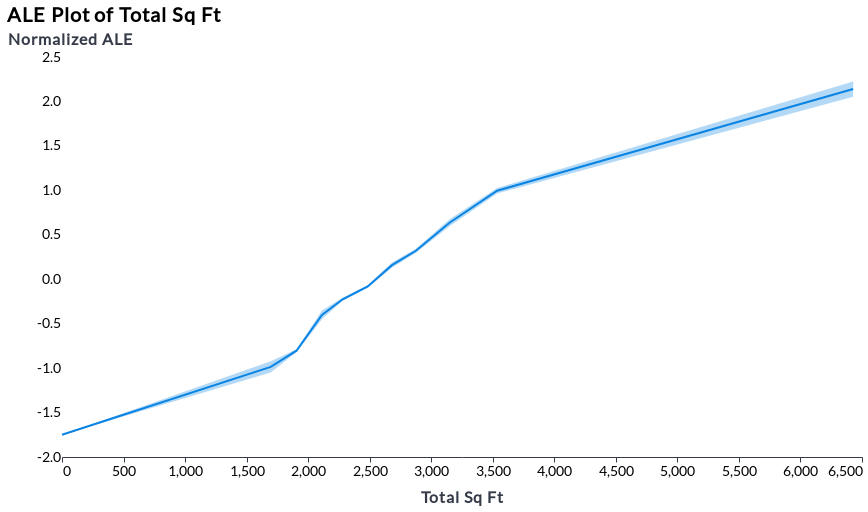

In [381]:
tdf = get_ALE(x_train, "TotalSF", 10)

base = alt.Chart(tdf, title="ALE Plot of Total Sq Ft")

line = base.mark_line(color = flatui['blue']).encode(
    x=alt.X("x", axis=alt.Axis(title="Total Sq Ft")),
    y=alt.Y("y", axis=alt.Axis(title="Normalized ALE")),
)

confidence_interval = (
    base.mark_area(color = flatui['blue'],opacity=0.3)
    .encode(x="x", y=alt.Y("ci_u:Q"), y2="ci_l:Q")
    .transform_calculate(ci_u="datum.y + datum.stdevs", ci_l="datum.y - datum.stdevs")
)

(confidence_interval + line).properties(height = 400, width = 800)

While the ALE plot looks fairly similar to the PDP plot this may not always be the case. I added in the standard deviation of each bin to the plot so that you can see the variability across the bins. Some of the variability will be due to the model not having enough data points in that range to produce an accurate prediction, this helps to place a bound on any resulting assumptions you may make from the ALE plot.

## Ending

There is a reason why Random Forest and its derivative algorithms are widely used. It is a very robust and highly interpretable algorithm. It is easy to implement and should be a starting point for most analysis if the data lends itself. Feature importance is a quick way to trim down wide datasets and point you in the right direction of where to focus your analysis. When implemented in decision making, tree interpreter helps to quickly explain how the model arrived at the prediction. PDP and ALE are able to show the true effects of a variable on a dependent variable better than a scatter plot. 

Thank you for reading. 


